In [1]:
# Download important libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)
import json
import os
from os import path
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import nltk

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

from nltk.tokenize import sent_tokenize
import warnings
warnings.filterwarnings('ignore')

In [2]:
def clean_df(df):
    df = df[df.caption != '']
    return df.reset_index(drop=True)

In [4]:
def df_rest_attr(fpath = '../data/spark/rest_descr.json'):
    df = pd.read_json(fpath)
    filters = ['Live music venue','Convenience store', 'Vaporizer store','Book store','Wedding venue',
               'Asian grocery store','Association or organization','Caterer','Culinary school','Sports nutrition store']
    df = df[~df['rest_type'].isin(filters) ]
    df['rest_type'] = df['rest_type'].str.replace('Korean barbecue restaurant' , 'Korean restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Chinese takeaway' , 'Chinese restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Delivery Chinese restaurant' , 'Chinese restaurant')
    df['rest_type'] = df['rest_type'].str.replace('中餐馆' , 'Chinese restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Sushi takeaway' , 'Sushi restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Pizza delivery' , 'Pizza restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Pizza delivery' , 'Pizza restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Northern Italian restaurant' , 'Italian restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Pizza Takeout' , 'Brunch restaurant')
    
    df['rest_type'] = df['rest_type'].str.replace('Asian fusion restauran' , 'Asian restauran')
    
    mask = df['rest_type'].str.contains(r'African', na=True)
    df.loc[mask, 'rest_type'] = 'African restaurant'
    
    mask = df['rest_type'].str.contains(r'Chinese', na=True)
    df.loc[mask, 'rest_type'] = 'Chinese restaurant'
    
    mask = df['rest_type'].str.contains(r'Chicken', na=True)
    df.loc[mask, 'rest_type'] = 'Chicken restaurant'
    df['rest_type'] = df['rest_type'].str.replace('Conveyor belt sushi restaurant' , 'Sushi restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Brewpub' , 'Pubs and Bar',regex=True)
#     df['rest_type'] = df['rest_type'].str.replace('Pub' , 'Pubs and Bar',regex=False)
    df['rest_type'] = df['rest_type'].str.replace('Gastropub' , 'Pubs and Bar',regex=False)
    df['rest_type'] = df['rest_type'].str.replace('Cocktail bar' , 'Pubs and Bar',regex=False)
    df['rest_type'] = df['rest_type'].str.replace('Wine bar' , 'Pubs and Bar',regex=False)
    df['rest_type'] = df['rest_type'].str.replace('Tiki bar' , 'Pubs and Bar',regex=False)
    df['rest_type'] = df['rest_type'].str.replace('Lounge' , 'Pubs and Bar',regex=False)
    df['rest_type'] = df['rest_type'].str.replace('Night club' , 'Pubs and Bar',regex=False)

    df['rest_type'] = df['rest_type'].str.replace('Beer garden' , 'Pubs and Bar',regex=False)
    df['rest_type'] = df['rest_type'].str.replace('Chicken wings restaurant' , 'Chicken restaurant',regex=False)

    df['rest_type'] = df['rest_type'].str.replace('Hookah bar' , 'Pubs and Bar',regex=False)
    df['rest_type'] = df['rest_type'].str.replace('Oyster bar restaurant' , 'Seafood restaurant',regex=False)
    
    df['rest_type'] = df['rest_type'].str.replace('Crêperie' , 'French restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Coffee shop' , 'Cafe')
    df['rest_type'] = df['rest_type'].str.replace('Bistro' , 'Cafe')
    df['rest_type'] = df['rest_type'].str.replace('Taco restaurant' , 'Mexican restaurant')
    df['rest_type'] = df['rest_type'].str.replace('Modern Indian restaurant' , 'Indian restaurant')

    
    df['rest_type'] = df['rest_type'].str.replace('New American restaurant' , 'American restaurant')

    df['rest_type'] = df['rest_type'].str.replace('Traditional American restaurant' , 'American restaurant')

    
    return df

In [5]:
df_rest_descr = df_rest_attr()
print(df_rest_descr['rest_type'].nunique())
df_rest_descr['rest_type'].unique()

447


array(['Restaurant', 'African restaurant', 'Takeout Restaurant',
       'Barbecue restaurant', 'Health food restaurant',
       'Mexican restaurant', 'American restaurant', 'Bar & grill',
       'Pubs and Bar', 'Pizza restaurant', 'Southern restaurant (US)',
       'Korean restaurant', 'Cafe', 'Sandwich shop', 'Asian restaurant',
       'French restaurant', '', 'Mediterranean restaurant',
       'Austrian restaurant', 'Japanese restaurant', 'Thai restaurant',
       'Chinese restaurant', 'Falafel restaurant', 'Hamburger restaurant',
       'Seafood restaurant', 'Lebanese restaurant', 'Sushi restaurant',
       'Afghani restaurant', 'Indian restaurant', 'Italian restaurant',
       'Fast food restaurant', 'Nepalese restaurant',
       'Ethiopian restaurant', 'Jamaican restaurant',
       'Chicken restaurant', 'Spanish restaurant',
       'Latin American restaurant', 'Persian restaurant',
       'Caribbean restaurant', 'Ramen restaurant',
       'Salvadoran restaurant', 'Filipino restaur

In [6]:
df_rest = pd.read_parquet('../data/spark/restaurants/restaurants.parq')
df_rest = df_rest.drop_duplicates(subset = ['place_id'], keep='first')
df_rest.sample(2)

,business_status,geometry,icon,name,opening_hours,photos,place_id,plus_code,reference,scope,types,vicinity,rating,user_ratings_total,CBG,Radius,price_level,permanently_closed
14084,OPERATIONAL,"{'location': {'lat': 40.7005373, 'lng': -73.81...",https://maps.gstatic.com/mapfiles/place_api/ic...,Sikder's Halal Food,{'open_now': True},"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJ9wXhNophwokRN8b6zhFHSS8,"{'compound_code': 'P52M+6G New York, NY, USA',...",ChIJ9wXhNophwokRN8b6zhFHSS8,GOOGLE,"[restaurant, food, point_of_interest, establis...","8900 Van Wyck Expressway, Queens",4.8,13.0,360810142021,254.150343,NaN,NaN
21220,CLOSED_TEMPORARILY,"{'location': {'lat': 34.0978448, 'lng': -118.3...",https://maps.gstatic.com/mapfiles/place_api/ic...,Ciabatta Bar,None,"[{'height': 2448, 'html_attributions': ['<a hr...",ChIJNSkYfDq_woARa5dQL8GpIy0,"{'compound_code': '3MX9+4F Hollywood, Los Ange...",ChIJNSkYfDq_woARa5dQL8GpIy0,GOOGLE,"[restaurant, food, point_of_interest, establis...","6464 Sunset Boulevard, Hollywood",4.4,33.0,60371908022,278.773033,NaN,1.0


In [7]:
df_rest_descr = df_rest_attr()
print(len(df_rest_descr))
df_join = df_rest_descr.join(df_rest.set_index('place_id'), on='place_id', how='left')
df_join.groupby(['rest_type'])['rating'].size().sort_values(ascending=False)[:10]

22677


rest_type
Restaurant              3268
African restaurant      2270
Mexican restaurant      1313
                        1234
Pizza restaurant        1089
Chinese restaurant      1086
Cafe                     917
American restaurant      800
Sandwich shop            784
Fast food restaurant     633
Name: rating, dtype: int64

In [8]:
st_time = time.time()
rev_dpath = '../data/outputs/reviews/'
        
rev_files = [rev_dpath+ f for f in os.listdir(rev_dpath)]
folds = len(rev_files)//2000
for i in range(folds+1):
    parq_dpath = '../data/spark/reviews/'
    parq_fname = '../data/spark/reviews/review_fold_' + str(i) + '.parq'
    parq_files = [parq_dpath+ f for f in os.listdir(parq_dpath)]
    if parq_fname not in parq_files[:-1]:
        df_rev = pd.DataFrame()
        if ((i+1)*2000 )< len(rev_files):
            rev_files_fold = rev_files[i*2000:(i+1)*2000]
        else:
            rev_files_fold = rev_files[i*2000:]
        for file in rev_files_fold:

            df = pd.read_json(file)

            df['place_id'] = file.split('_',1)[1]
            df['place_id'] = df['place_id'].str.replace('.json','')
            df_rev = pd.concat((df_rev, df), ignore_index=True)

        df_rev.to_parquet(parq_fname)
        print('Fold ',str(i), ' Done. Time Taken = ',time.time()-st_time)
    

Fold  9  Done. Time Taken =  330.9055743217468


In [9]:
rev_parq_dir = '../data/spark/reviews/'
parq_files = [rev_parq_dir+ f for f in os.listdir(rev_parq_dir) if os.path.isfile(rev_parq_dir+ f)]
df_review = pd.DataFrame()
for file in parq_files:
    df_fold = pd.read_parquet(file)
    df_review = pd.concat((df_review, df_fold), ignore_index=True)
df_review = clean_df(df_review)
df_review = df_review.drop_duplicates(subset = ['id_review'], keep='first')
print(len(df_review))
df_review.sample(2)

1974769


,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,census_block_group,place_id
262552,ChZDSUhNMG9nS0VJQ0FnSUNvX2JuZmZnEAE,Dont come here if you dont want to breathe inc...,2 years ago,2021-03-26,1,Raymond Young,2,0,https://www.google.com/maps/contrib/1070063805...,150030052002,ChIJP6UD73ZuAHwRfWMiEctt5jQ
1495937,ChdDSUhNMG9nS0VJQ0FnSUMwOG9ydndnRRAB,The best place for vietnamese hoguie and deserts,a year ago,2021-04-09,5,Dan Nguy,0,0,https://www.google.com/maps/contrib/1162481060...,421010025004,ChIJm4xfgaDIxokRe2QLjv1Un6I


In [8]:
'''
rev_dpath = '../data/outputs/cbg_restaurants/'
        
rev_files = [rev_dpath+ f for f in os.listdir(rev_dpath)][:-1]
df_rest = pd.DataFrame()
for file in rev_files:
    
    df = pd.read_json(file)

    df_rest = pd.concat((df_rest, df), ignore_index=True)
df_rest.to_parquet('../data/spark/reviews/restaurants.parq')
df_rest = df_rest.drop_duplicates(subset = ['place_id'], keep='first')
'''

"\nrev_dpath = '../data/outputs/cbg_restaurants/'\n        \nrev_files = [rev_dpath+ f for f in os.listdir(rev_dpath)][:-1]\ndf_rest = pd.DataFrame()\nfor file in rev_files:\n    \n    df = pd.read_json(file)\n\n    df_rest = pd.concat((df_rest, df), ignore_index=True)\ndf_rest.to_parquet('../data/spark/reviews/restaurants.parq')\ndf_rest = df_rest.drop_duplicates(subset = ['place_id'], keep='first')\n"

In [10]:
df_merge = df_review.join(df_rest.set_index('place_id'), on='place_id', rsuffix= '_restaurant',how='inner')
print(len(df_merge))
df_merge.sample(2)

1974769


,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,census_block_group,...,reference,scope,types,vicinity,rating_restaurant,user_ratings_total,CBG,Radius,price_level,permanently_closed
1371927,ChZDSUhNMG9nS0VJQ0FnSUNBM19hb0RREAE,Excellent peruvian chicken. Full flavored and...,4 years ago,2021-04-08,5,Michael Lesley,0,0,https://www.google.com/maps/contrib/1016179933...,360811181001,...,ChIJwbiqRtBhwokRWpNJIVJALb8,GOOGLE,"[restaurant, food, point_of_interest, establis...","196-17 Northern Boulevard, Queens",4.3,207.0,360811181001,189.176057,NaN,NaN
1553251,ChdDSUhNMG9nS0VJQ0FnSURRdl95Y2xnRRAB,Super Hospitable! Big portions. Do yourself a ...,2 years ago,2021-04-10,5,Nihjer Richardson,3,0,https://www.google.com/maps/contrib/1011217650...,480291101002,...,ChIJ33vZxVJfXIYR5kzYtgCS4aw,GOOGLE,"[restaurant, food, point_of_interest, establis...","124 North Main Avenue, San Antonio",4.6,440.0,480291101002,462.336410,2.0,NaN


In [12]:
def clean_merge(df):
#     df = df[df.caption.str.len() > 25]
    mask = df.caption.str.contains('\(Original\)')
    df.caption.loc[mask] = df.caption[mask].str.split('\(Original\)').str[0]
    df.caption = df.caption.str.replace('\(Translated by Google\)','')
#     df.caption = df.caption.replace('(Original)','')
    return df

In [13]:
df_merge_clean = clean_merge(df_merge)
print(len(df_merge_clean))
df_merge_clean.sample(2)

1974769


,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,census_block_group,...,reference,scope,types,vicinity,rating_restaurant,user_ratings_total,CBG,Radius,price_level,permanently_closed
1401200,ChdDSUhNMG9nS0VJQ0FnSURBaGNMczNRRRAB,My favorite Indian food in Ithaca!,3 years ago,2021-04-08,5,Jennifer Henion,0,0,https://www.google.com/maps/contrib/1066298420...,361090001001,...,ChIJdQUbTJyB0IkRATx_-B0wSOA,GOOGLE,"[restaurant, food, point_of_interest, establis...","106 West Green Street, Ithaca",4.2,476.0,361090001001,403.045050,2.0,NaN
793947,ChdDSUhNMG9nS0VJQ0FnSUNJc3Q3SWdRRRAB,Amazing Indian food! The best Indian food I ha...,2 years ago,2021-04-01,5,Aditya Jain,0,0,https://www.google.com/maps/contrib/1123506244...,360470009001,...,ChIJ4yVW4UhawokRUCnb9yh9xaw,GOOGLE,"[meal_delivery, meal_takeaway, restaurant, foo...","151 Remsen Street, Brooklyn",4.0,469.0,360470009001,185.768363,2.0,NaN


In [14]:
df_merge_clean = df_merge_clean[df_merge_clean['rating']!=3]
print(len(df_merge_clean))

1828739


In [15]:
def sentiment(x):
    if x<=2:
        return 0
    return 1

In [16]:
df_merge_clean['sentiment'] = df_merge_clean['rating'].apply(lambda x: sentiment(x))

1    85.77
0    14.23
Name: sentiment, dtype: float64


<AxesSubplot:>

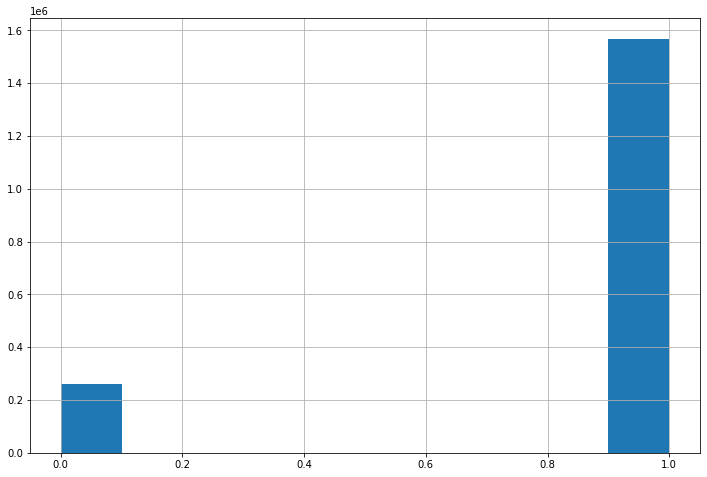

In [17]:
print(np.round(df_merge_clean['sentiment'].value_counts()*100/len(df_merge_clean),2))
plt.figure(figsize=(12,8))
df_merge_clean['sentiment'].hist()


In [18]:

english_stops = set(stopwords.words('english'))

def load_dataset(df):
    
    x_data = df['caption']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ' '}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True) # remove non alphabet
    
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review]) # lower case
#     x_data = x_data.apply(lambda review: [lemmatizer.lemmatize(w) for w in review]) 
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset(df_merge_clean)

print('Reviews')
print(x_data[:5], '\n')
print('Sentiment')
print(y_data[:5])

Reviews
0                         [one, new, favorite, places]
1    [i, got, peanut, butter, cup, shake, really, g...
2    [love, place, i, recommend, cucumber, watermel...
3                                [everything, amazing]
4    [the, bacon, egg, cheese, biscuits, put, sleep...
Name: caption, dtype: object 

Sentiment
0    1
1    1
2    1
3    1
4    1
Name: sentiment, dtype: int64


In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1) 

print('Train Set')
print(x_train[:5], '\n')
print(x_test[:5], '\n')
print('Test Set')
print(y_train[:5], '\n')
print(y_test[:5])

Train Set
1570033                       [best, mexican, food, i, ever]
302609     [when, i, first, walked, i, impressed, atmosph...
769727     [had, impossible, burger, today, i, say, taste...
2020444    [good, food, friendly, people, a, little, priced]
913242     [great, selection, bagels, sandwiches, delicious]
Name: caption, dtype: object 

703658     [it, favorite, restaurant, town, husband, i, r...
1104965    [dunkin, donuts, need, take, care, franchise, ...
1377291    [food, great, tacos, pork, chops, fajita, burr...
56415        [delicious, quickly, a, bit, simple, therefore]
1581387                                      [i, love, food]
Name: caption, dtype: object 

Test Set
1570033    1
302609     1
769727     1
2020444    1
913242     1
Name: sentiment, dtype: int64 

703658     1
1104965    0
1377291    1
56415      1
1581387    1
Name: sentiment, dtype: int64


In [20]:

def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Bidirectional # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model

In [22]:

# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_val = token.texts_to_sequences(x_val)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post', truncating='post')

x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[     9    214      2 ...      0      0      0]
 [   268      1     67 ...      7     41    133]
 [   204   1756    112 ...      0      0      0]
 ...
 [     3      2    556 ...      0      0      0]
 [   397   7518      8 ...      0      0      0]
 [    43    273 120656 ...    287     67     15]] 

Encoded X Test
 [[   17    66    23 ...   123    15   435]
 [ 1254   747   209 ...     1    71  1254]
 [    2     3   117 ...     0     0     0]
 ...
 [35475   154  1251 ...     0     0     0]
 [  285     4    26 ...     0     0     0]
 [  600     4     0 ...     0     0     0]] 

Maximum review length:  14


In [23]:
x = token.word_index
{k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=False)}

{'i': 1,
 'food': 2,
 'great': 3,
 'good': 4,
 'the': 5,
 'service': 6,
 'place': 7,
 'delicious': 8,
 'best': 9,
 'staff': 10,
 'nice': 11,
 'friendly': 12,
 'love': 13,
 'amazing': 14,
 'time': 15,
 'go': 16,
 'it': 17,
 'like': 18,
 'always': 19,
 'excellent': 20,
 'one': 21,
 'back': 22,
 'restaurant': 23,
 'we': 24,
 'really': 25,
 'pizza': 26,
 'order': 27,
 'get': 28,
 'this': 29,
 'they': 30,
 'chicken': 31,
 'very': 32,
 'atmosphere': 33,
 'would': 34,
 'recommend': 35,
 'fresh': 36,
 'well': 37,
 'also': 38,
 'awesome': 39,
 'definitely': 40,
 'ordered': 41,
 'menu': 42,
 'my': 43,
 'eat': 44,
 'drinks': 45,
 'people': 46,
 'even': 47,
 'ever': 48,
 'try': 49,
 'never': 50,
 'got': 51,
 'spot': 52,
 'prices': 53,
 'experience': 54,
 'little': 55,
 'come': 56,
 'tasty': 57,
 'customer': 58,
 'us': 59,
 'fast': 60,
 'a': 61,
 'everything': 62,
 'wait': 63,
 'price': 64,
 'lunch': 65,
 'favorite': 66,
 'first': 67,
 'bar': 68,
 'super': 69,
 'made': 70,
 'went': 71,
 'quality': 

In [24]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [49]:
EMBED_DIM = 64
LSTM_OUT = 64

# define model_CNN
model_CNN = Sequential()
model_CNN.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
model_CNN.add(Conv1D(filters=128, kernel_size=8, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(32, activation='relu'))
model_CNN.add(Dense(1, activation='sigmoid'))
print(model_CNN.summary())
model_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_CNN.fit(x_train, y_train, validation_data= (x_val,y_val),batch_size = 128, epochs = 3)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 18, 64)            5638848   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 11, 128)           65664     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                20512     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 5,725,057
Trainable params: 5,725,057
Non-trainable params: 0
___________________________________________

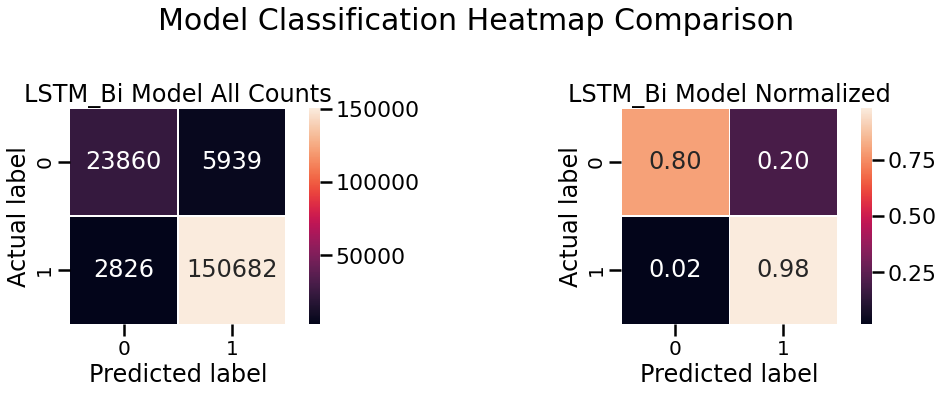

Accuracy: 95.21840409804318


In [50]:
y_pred = model.predict_classes(x_test, batch_size = 128)

import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix

import seaborn as sns

fig = plt.figure(figsize=(15,10))

fig.suptitle('Model Classification Heatmap Comparison\n\n',fontsize=30, x= 0.55, y = 0.9)

ax1 = plt.subplot(221); plot_heatmap_mat(y_test,y_pred,normalize=False,classes = [0,1])
ax1.title.set_text('LSTM_Bi Model All Counts')

ax2 = plt.subplot(222); plot_heatmap_mat(y_test,y_pred,normalize=True,classes = [0,1])
ax2.title.set_text('LSTM_Bi Model Normalized')


plt.tight_layout()
plt.show()

print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)*100))


In [262]:

# ARCHITECTURE
EMBED_DIM = 64
LSTM_OUT = 64

model_RNN_LSTM = Sequential()
model_RNN_LSTM.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model_RNN_LSTM.add((LSTM(LSTM_OUT,return_sequences=False)))
model_RNN_LSTM.add(Dense(1, activation='sigmoid'))
model_RNN_LSTM.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model_RNN_LSTM.summary())
model_RNN_LSTM.fit(x_train, y_train, validation_data= (x_val,y_val),batch_size = 128, epochs = 3)


Epoch 1/3
4682/4682 [==============================] - 192s 41ms/step - loss: 0.1354 - accuracy: 0.9489 - val_loss: 0.1177 - val_accuracy: 0.9560
Epoch 2/3
4682/4682 [==============================] - 193s 41ms/step - loss: 0.1053 - accuracy: 0.9606 - val_loss: 0.1138 - val_accuracy: 0.9573
Epoch 3/3
4682/4682 [==============================] - 192s 41ms/step - loss: 0.0908 - accuracy: 0.9662 - val_loss: 0.1157 - val_accuracy: 0.9567


In [25]:

# ARCHITECTURE
EMBED_DIM = 64
LSTM_OUT = 64

model_RNN_LSTM_Bi = Sequential()
model_RNN_LSTM_Bi.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model_RNN_LSTM_Bi.add(Bidirectional(LSTM(LSTM_OUT,return_sequences=False)))
model_RNN_LSTM_Bi.add(Dense(1, activation='sigmoid'))
model_RNN_LSTM_Bi.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model_RNN_LSTM_Bi.summary())
model_RNN_LSTM_Bi.fit(x_train, y_train, validation_data= (x_val,y_val),batch_size = 128, epochs = 3)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 64)            7722112   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 7,788,289
Trainable params: 7,788,289
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
10287/10287 [==============================] - 544s 53ms/step - loss: 0.1260 - accuracy: 0.9524 - val_loss: 0.1140 - val_accuracy: 0.9571
Epoch 2/3
10287/10287 [==============================] - 533s 52ms/step - loss: 0.1026 - accuracy: 0.9616 - val_loss: 0.1117 - val_accuracy: 0.9584
Epoch 3/3
10287/10287 [==============================] - 547s 53ms/step - l

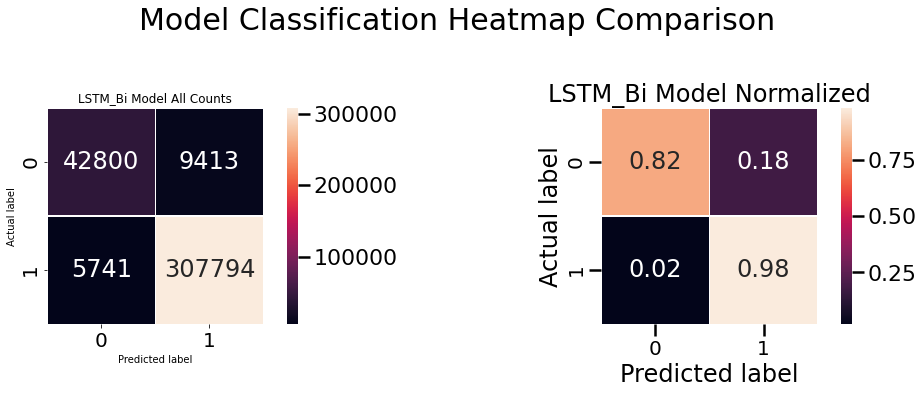

Accuracy: 95.85671008453907


In [28]:
y_pred = model_RNN_LSTM_Bi.predict_classes(x_test, batch_size = 128)

import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix

import seaborn as sns

fig = plt.figure(figsize=(15,10))

fig.suptitle('Model Classification Heatmap Comparison\n\n',fontsize=30, x= 0.55, y = 0.9)

ax1 = plt.subplot(221); plot_heatmap_mat(y_test,y_pred,normalize=False,classes = [0,1])
ax1.title.set_text('LSTM_Bi Model All Counts')

ax2 = plt.subplot(222); plot_heatmap_mat(y_test,y_pred,normalize=True,classes = [0,1])
ax2.title.set_text('LSTM_Bi Model Normalized')


plt.tight_layout()
plt.show()

print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)*100))


In [29]:
pd.set_option('display.max_colwidth', 120)
y_pred_ser = pd.Series(y_pred.flatten(),index=y_test.index)
df_merge_clean.loc[y_test[y_test!=y_pred_ser].index][['caption','rating']]

,caption,rating
667055,Food was great it was wrong and my girl at the bar who is always helpful fixed the issue. Now here is my problem the...,1
834031,Saw this place on tv and came all the way from central jersey. Took two large knafeh to go because that’s what the ...,2
2214041,"I'm not sure why there's pictures of tables here, because this place is a Chinese BBQ and meat market. There is not...",4
1049758,Like the decor and atmosphere. I always get the chilaquiles for brunch. This time chilaquiles were ok. Nothing to wr...,4
364330,Why allow Frontera Fresco to use Rick Bayless name ...Frontera Fresco is a joke... I would remove my name from that ...,1
...,...,...
1540163,Tried the tacos. Crunchy version of Jack n the Box tacos. I'll pass.,2
1930027,Order the angry bee. You won't be disappointed,5
332090,"Since I walked in this great place, the OWNER found my table to be seated. The busboy, started bringing the water an...",5
1645413,"Pad Thai was bland, but the Gang Dang curry was delicious, and was so super happy to find a Thai place that served ...",1


<AxesSubplot:>

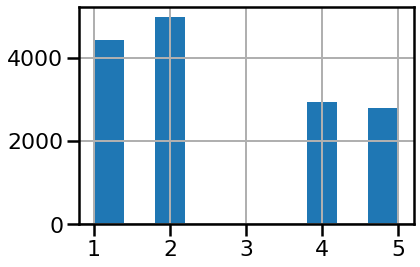

In [30]:

df_merge_clean.loc[y_test[y_test!=y_pred_ser].index]['rating'].hist()

In [277]:

# ARCHITECTURE
EMBED_DIM = 64
LSTM_OUT = 64

model_RNN_GRU = Sequential()
model_RNN_GRU.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model_RNN_GRU.add((GRU(LSTM_OUT,return_sequences=False)))
model_RNN_GRU.add(Dense(1, activation='sigmoid'))
model_RNN_GRU.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model_RNN_GRU.summary())
model_RNN_GRU.fit(x_train, y_train, validation_data= (x_val,y_val),batch_size = 128, epochs = 3)


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 18, 64)            5777856   
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 5,802,881
Trainable params: 5,802,881
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
4682/4682 [==============================] - 189s 40ms/step - loss: 0.1346 - accuracy: 0.9489 - val_loss: 0.1172 - val_accuracy: 0.9553
Epoch 2/3
4682/4682 [==============================] - 187s 40ms/step - loss: 0.1047 - accuracy: 0.9603 - val_loss: 0.1155 - val_accuracy: 0.9568
Epoch 3/3
4682/4682 [==============================] - 189s 40ms/step - loss

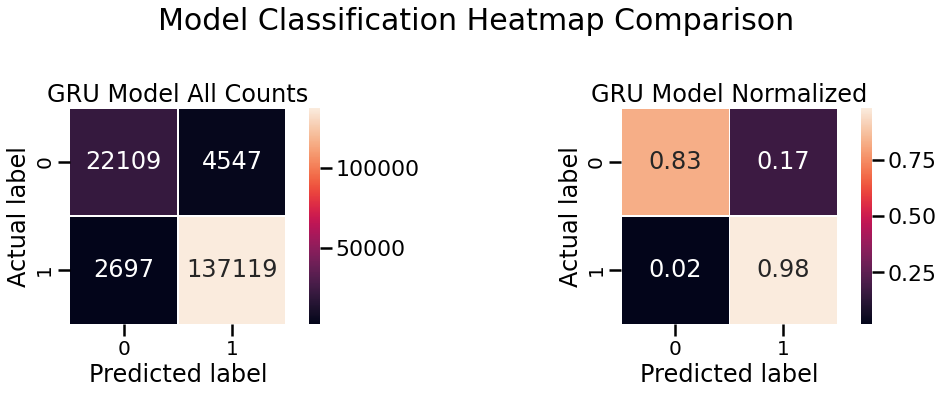

Accuracy: 95.6485174684031


In [278]:
y_pred = model_RNN_GRU.predict_classes(x_test, batch_size = 128)

import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix

import seaborn as sns

fig = plt.figure(figsize=(15,10))

fig.suptitle('Model Classification Heatmap Comparison\n\n',fontsize=30, x= 0.55, y = 0.9)

ax1 = plt.subplot(221); plot_heatmap_mat(y_test,y_pred,normalize=False,classes = [0,1])
ax1.title.set_text('GRU Model All Counts')

ax2 = plt.subplot(222); plot_heatmap_mat(y_test,y_pred,normalize=True,classes = [0,1])
ax2.title.set_text('GRU Model Normalized')


plt.tight_layout()
plt.show()

print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)*100))


In [27]:
def plot_heatmap_mat(y_test,pred,classes,normalize=False ):
    sns.set_context("poster", rc={"font.size":24})   
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        plot = sns.heatmap(norm_conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes, fmt='.2f',
                    linewidths=.5)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        return plot
    else:
        plot = sns.heatmap(conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes,fmt='d',
                    linewidths=.5)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        return plot

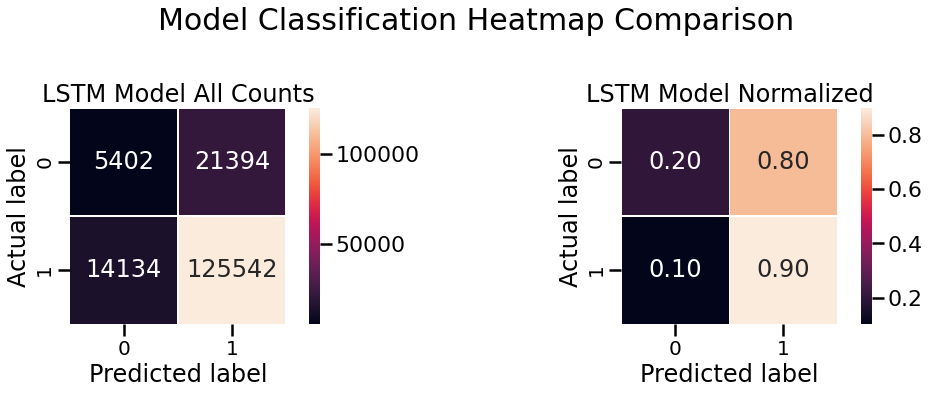

Accuracy: 78.65827286270364


In [299]:
y_pred = model_RNN_LSTM.predict_classes(x_test, batch_size = 128)

import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix

import seaborn as sns

fig = plt.figure(figsize=(15,10))

fig.suptitle('Model Classification Heatmap Comparison\n\n',fontsize=30, x= 0.55, y = 0.9)

ax1 = plt.subplot(221); plot_heatmap_mat(y_test,y_pred,normalize=False,classes = [0,1])
ax1.title.set_text('LSTM Model All Counts')

ax2 = plt.subplot(222); plot_heatmap_mat(y_test,y_pred,normalize=True,classes = [0,1])
ax2.title.set_text('LSTM Model Normalized')


plt.tight_layout()
plt.show()

print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)*100))


In [23]:
import string

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [24]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [25]:
import re

In [27]:
train_text = df_merge_clean['caption'].values
vectorize_layer.adapt(train_text)

In [28]:

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [31]:
raw_train_ds = df_merge_clean[['caption', 'sentiment']].values

In [44]:
import tensorflow_datasets as tfds
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

GPU is available


Dataset imdb_reviews downloaded and prepared to C:\Users\swami\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [49]:
train_data.take(1)

<TakeDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [32]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

TypeError: 'int' object is not subscriptable

In [38]:
 seed =42
tf.keras.preprocessing.text(
    raw_train_ds, 
    batch_size=32, 
    validation_split=0.2, 
    subset='training')

TypeError: 'module' object is not callable

In [50]:
url = 'https://github.com/hansmichaels/sentiment-analysis-IMDB-Review-using-LSTM/blob/master/sentiment_analysis.py.ipynb'
url

'https://github.com/hansmichaels/sentiment-analysis-IMDB-Review-using-LSTM/blob/master/sentiment_analysis.py.ipynb'